# Image inpainting and outpainting with FLUX.1 Fill

inpainting is task of replacing or editing specific area of input image. This makes it a useful tool for image restoration like removing defects and artifacts, or even replacing an image area with something entirely new. Inpainting relies on a mask to determine which regions of an image to fill in; the area to inpaint is represented by white pixels and the area to keep is represented by black pixels. The white pixels are filled in by the prompt.
FLUX.1 Fill introduces advanced inpainting capabilities that surpass existing approaches.  It allows for seamless edits that integrate naturally with existing images. 

![](https://github.com/user-attachments/assets/3598a8e1-526b-4571-8d73-200dcde92430)

Additionally, FLUX.1 Fill supports outpainting, enabling the user to extend images beyond their original borders.

![](https://github.com/user-attachments/assets/0e195ef2-fc5d-4eca-b32f-08cdd646199f)

You can find more details about model in [blog post](https://blackforestlabs.ai/flux-1-tools/) and [model card](https://huggingface.co/black-forest-labs/FLUX.1-Fill-dev)

In this tutorial, we consider how to convert and optimize FLUX.1 Fill for performing image editing using text prompt and binary mask.
#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Convert model with OpenVINO](#Convert-model-with-OpenVINO)
    - [Convert model using Optimum Intel](#Convert-model-using-Optimum-Intel)
    - [Compress model weights](#Compress-model-weights)
- [Run OpenVINO model inference](#Run-OpenVINO-model-inference)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/flux-fill/flux-fill.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
import platform
import requests
from pathlib import Path

utility_files = ["cmd_helper.py", "notebook_utils.py"]
base_utility_url = "https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/"

for utility_file in utility_files:
    if not Path(utility_file).exists():
        r = requests.get(base_utility_url + utility_file)
        with Path(utility_file).open("w") as f:
            f.write(r.text)

%pip install -q "gradio>=4.19" "torch>=2.1"  "transformers" "diffusers>=0.32.0" "opencv-python" "pillow" "peft>=0.7.0" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "sentencepiece" "protobuf"
%pip install -q "git+https://github.com/huggingface/optimum-intel.git"  --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -qU "openvino>=2025.0.0" "nncf>=2.15.0"

if platform.system() == "Darwin":
    %pip install -q "numpy<2.0"

>**Note**: run Flux.1-Fill-dev model with notebook, you will need to accept license agreement. 
>You must be a registered user in 🤗 Hugging Face Hub. Please visit [HuggingFace model card](https://huggingface.co/black-forest-labs/FLUX.1-Fill-dev), carefully read the terms of usage, and click the accept button.  You will need to use an access token for the code below to run. For more information on access tokens, refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).
>You can login on to Hugging Face Hub in the notebook environment, using the following code:

In [2]:
# uncomment these lines to login to huggingfacehub to get access to pretrained model

# from huggingface_hub import notebook_login, whoami

# try:
#     whoami()
#     print('Authorization token already provided')
# except OSError:
#     notebook_login()

# Convert model with OpenVINO
[back to top ⬆️](#Table-of-contents:)

Starting from 2023.0 release, OpenVINO supports PyTorch models directly via Model Conversion API. `ov.convert_model` function accepts instance of PyTorch model and example inputs for tracing and returns object of `ov.Model` class, ready to use or save on disk using `ov.save_model` function. 


The pipeline consists of four important parts:

* Clip and T5 Text Encoders to create condition to generate an image from a text prompt.
* Transformer for step-by-step denoising latent image representation.
* Autoencoder (VAE) for encoding input image and mask and  decoding latent space to image.
  
### Convert model using Optimum Intel
[back to top ⬆️](#Table-of-contents:)

For convenience, we will use OpenVINO integration with HuggingFace Optimum. 🤗 [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) is the interface between the 🤗 Transformers and Diffusers libraries and the different tools and libraries provided by Intel to accelerate end-to-end pipelines on Intel architectures.

Among other use cases, Optimum Intel provides a simple interface to optimize your Transformers and Diffusers models, convert them to the OpenVINO Intermediate Representation (IR) format and run inference using OpenVINO Runtime. `optimum-cli` provides command line interface for model conversion and optimization. 

General command format:

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <output_dir>
```

where task is task to export the model for, if not specified, the task will be auto-inferred based on the model. You can find a mapping between tasks and model classes in Optimum TaskManager [documentation](https://huggingface.co/docs/optimum/exporters/task_manager). Additionally, you can specify weights compression using `--weight-format` argument with one of following options: `fp32`, `fp16`, `int8` and `int4`. Fro int8 and int4 [nncf](https://github.com/openvinotoolkit/nncf) will be used for  weight compression. More details about model export provided in [Optimum Intel documentation](https://huggingface.co/docs/optimum/intel/openvino/export#export-your-model).

### Compress model weights
[back to top ⬆️](#Table-of-contents:)

For reducing model memory consumption we will use weights compression. The [Weights Compression](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html) algorithm is aimed at compressing the weights of the models and can be used to optimize the model footprint and performance of large models where the size of weights is relatively larger than the size of activations, for example, Large Language Models (LLM). Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality. We will use [NNCF](https://github.com/openvinotoolkit/nncf) integration to `optimum-cli` tool for weight compression.


In [3]:
from cmd_helper import optimum_cli
import ipywidgets as widgets

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("flux-fill.ipynb")

to_compress = widgets.Checkbox(
    value=True,
    description="Weight compression",
    disabled=False,
)

to_compress

<frozen importlib.util>:247: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.


Checkbox(value=True, description='Weight compression')

In [4]:
model_id = "black-forest-labs/FLUX.1-Fill-dev"

model_base_dir = Path(model_id.split("/")[-1])
additional_args = {}

if to_compress.value:
    model_dir = model_base_dir / "INT4"
    additional_args.update({"weight-format": "int4", "group-size": "64", "ratio": "1.0"})
else:
    model_dir = model_base_dir / "FP16"
    additional_args.update({"weight-format": "fp16"})

if not model_dir.exists():
    optimum_cli(model_id, model_dir, additional_args=additional_args)

## Run OpenVINO model inference
[back to top ⬆️](#Table-of-contents:)

`OVDiffusionPipeline` from Optimum Intel provides ready-to-use interface for running Diffusers models using OpenVINO. It supports various models including Stable Diffusion, Stable Diffusion XL, LCM, Stable Diffusion v3 and Flux. Similar to original Diffusers pipeline, for initialization, we should use `from_preptrained` method providing model id from HuggingFace hub or local directory (both original PyTorch and OpenVINO models formats supported, in the first case model class additionally will trigger model conversion).

In [5]:
from notebook_utils import device_widget

device = device_widget(default="CPU", exclude=["NPU"])
device

Dropdown(description='Device:', options=('CPU', 'AUTO'), value='CPU')

In [6]:
import ipywidgets as widgets

model_available = (model_base_dir / "INT4").is_dir()
use_quantized_models = widgets.Checkbox(
    value=model_available,
    description="Use compressed models",
    disabled=not model_available,
)

use_quantized_models

Checkbox(value=True, description='Use compressed models')

In [7]:
from optimum.intel.openvino import OVDiffusionPipeline

model_dir = model_base_dir / "INT4" if use_quantized_models.value else model_base_dir / "FP16"

ov_pipe = OVDiffusionPipeline.from_pretrained(model_dir, device=device.value)

2025-02-06 22:52:20.058138: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 22:52:20.071147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738867940.086226  322985 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738867940.090599  322985 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 22:52:20.105783: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

When pipeline initialized, we can see model in action. Let's try to turn dog to cat!

In [8]:
from diffusers.utils import load_image, make_image_grid

input_image_path = Path("input_image.png")
input_mask_path = Path("input_mask.png")

if not input_image_path.exists():
    init_image = load_image("https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png")
    init_image.save(input_image_path)
else:
    init_image = load_image(str(input_image_path))

if not input_mask_path.exists():
    init_mask = load_image("https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png")
    init_mask.save(input_mask_path)
else:
    init_mask = load_image(str(input_mask_path))

  0%|          | 0/20 [00:00<?, ?it/s]

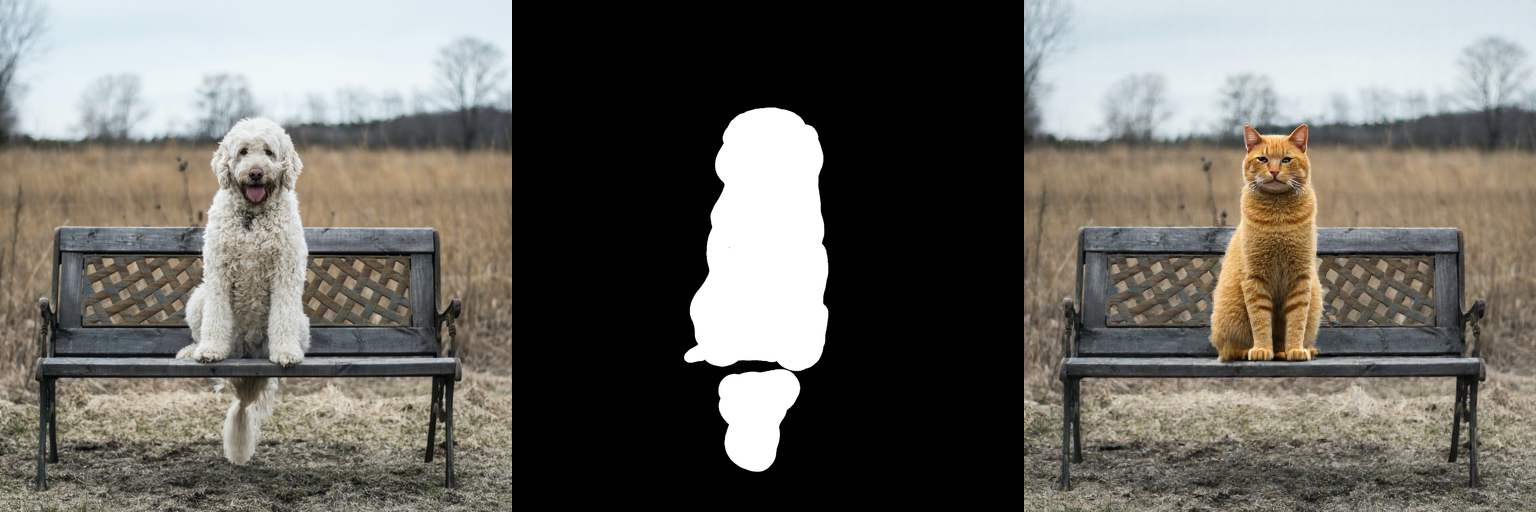

In [9]:
prompt = "A yellow cat, high resolution, sitting on a park bench"
image = ov_pipe(prompt=prompt, image=init_image, mask_image=init_mask, num_inference_steps=20, height=512, width=512).images[0]
make_image_grid([init_image, init_mask, image], rows=1, cols=3)

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
if not Path("gradio_helper.py").exists():
    r = requests.get("https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/flux-fill.gradio_helper.py")
    with open("grdio_helper.py", "w") as f:
        f.write(r.text)


from gradio_helper import make_demo

demo = make_demo(ov_pipe)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/